In [4]:
!pip install ftfy regex tqdm -q
!pip install git+https://github.com/openai/CLIP.git -q

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as transforms
from torchvision.transforms import RandAugment
from PIL import Image, ImageOps
import numpy as np
#import cv2
import matplotlib.pyplot as plt
import clip
import copy

import re
import pandas as pd
import random # TODO: Check if there is any import not used in the code

import boto3
from io import BytesIO
from pathlib import Path

In [5]:
!pip install wandb
import wandb
wandb.login()
# wandb config
WANDB_NOTEBOOK_NAME = "sagemaker"
# Initialize WandB
wandb.init(project="imagenet-adaptation-final")
columns = ["Original Label", "Baseline Label", "Adapted Label", "Prediction Changed"]
augmentation_table = wandb.Table(columns=columns)

In [5]:
class ImageNetADataset(Dataset):
    def __init__(self, root, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform

        # Read labels from README.txt
        self.labels = self.read_labels(root)

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)
            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png"):
                continue

            # Keep track of valid instances
            self.instances.append(key)

        # Extract classes from labels and sort them alphabetically
        self.classes = sorted(set(self.labels.values()))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.idx_to_class = {i: cls_name for cls_name, i in self.class_to_idx.items()} # reverse mapping for model TODO: Explain better
        self.n_label = len(self.classes)

    def read_labels(self, root):
        readme_key = f"{root}README.txt"
        try:
            response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=readme_key)
            readme_content = response["Body"].read().decode('utf-8')
            labels = self.parse_labels(readme_content)
            return labels
        except Exception as e:
            raise RuntimeError(f"Error reading README.txt: {str(e)}")

    def parse_labels(self, readme_content):
        labels = {}
        in_label_section = False
        for line in readme_content.splitlines():
            if "WordNet ID" in line:
                in_label_section = True
                continue
            if in_label_section:
                parts = line.split()
                if len(parts) >= 2:
                    folder_name = parts[0]
                    label = " ".join(parts[1:])
                    labels[folder_name] = label
        return labels

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        try:
            key = self.instances[idx]
            path = Path(key)

            # Download image from S3
            img_bytes = BytesIO()
            self.s3_client.download_fileobj(Bucket=self.s3_bucket, Key=key, Fileobj=img_bytes)
            img_bytes.seek(0)

            # Open image with PIL
            img = Image.open(img_bytes)

            # Apply transformations if any
            if self.transform is not None:
                img = self.transform(img)

            # Get the label from the parent directory name
            folder_name = path.parent.name
            label = self.labels[folder_name]
        except Exception as e:
            raise RuntimeError(f"Error loading image at index {idx}: {str(e)}")

        return img, self.class_to_idx[label]

Dataset length: 7500
Printing some file names and their corresponding labels:
File: imagenet-a/n01498041/0.000116_digital clock _ digital clock_0.865662.jpg, Label: stingray
File: imagenet-a/n01498041/0.000348_chameleon _ box turtle_0.55540705.jpg, Label: stingray
File: imagenet-a/n01498041/0.000376_oystercatcher _ oystercatcher_0.7287027.jpg, Label: stingray
File: imagenet-a/n01498041/0.000539_American alligator _ American alligator_0.85773236.jpg, Label: stingray
File: imagenet-a/n01498041/0.000682_jellyfish _ jellyfish_0.99729806.jpg, Label: stingray


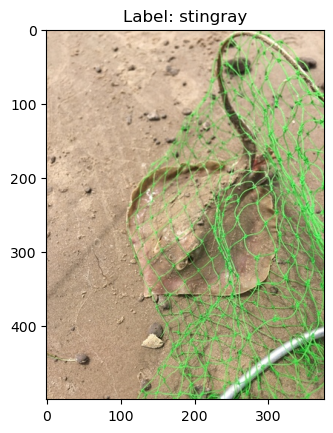

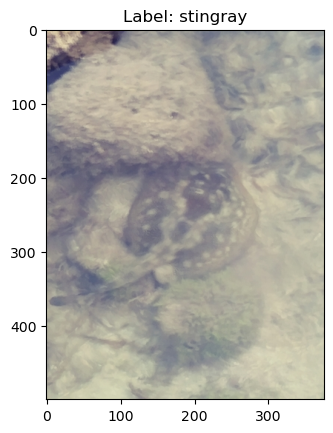

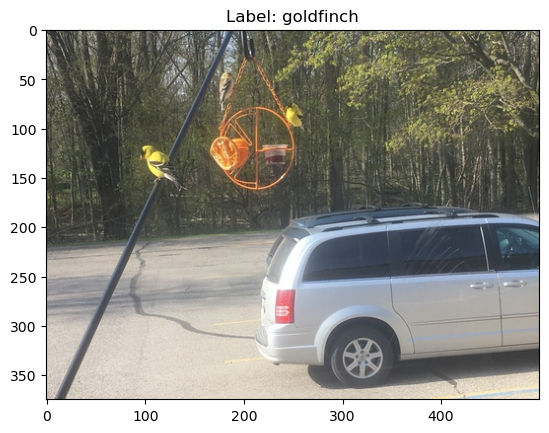

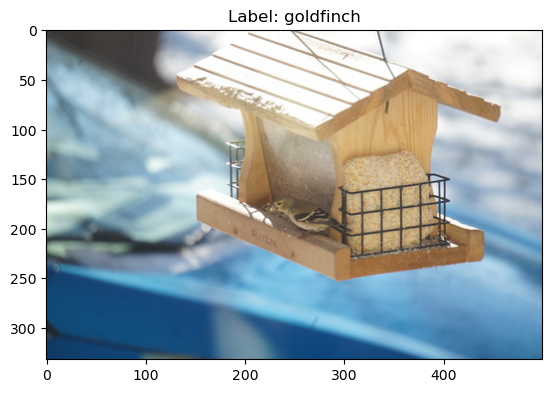

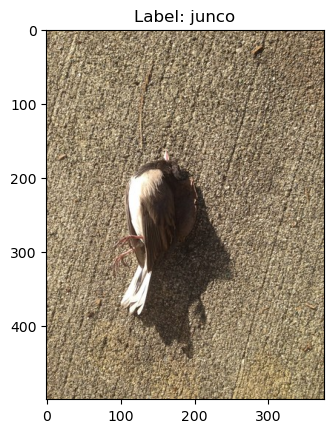

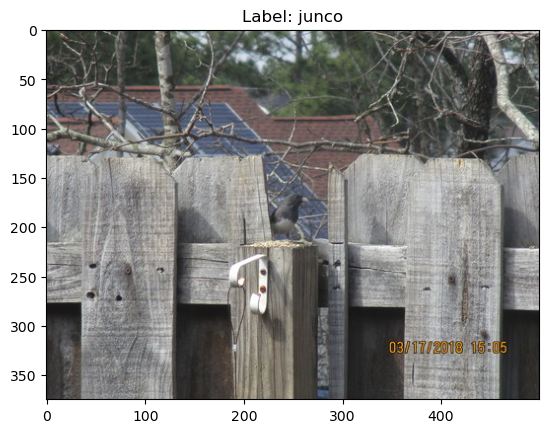

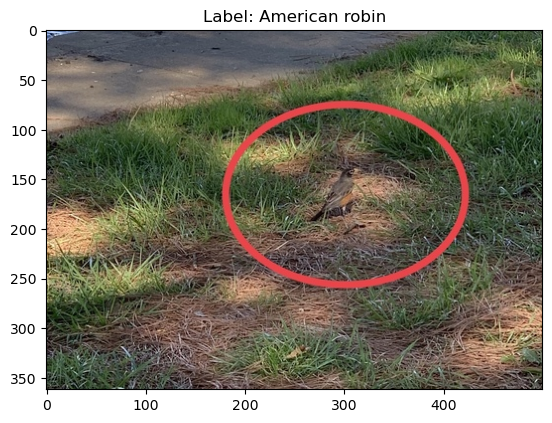

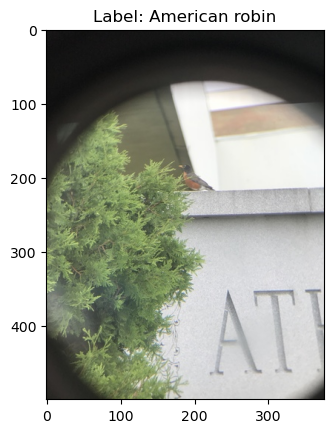

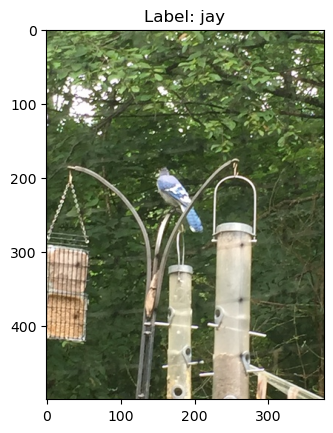

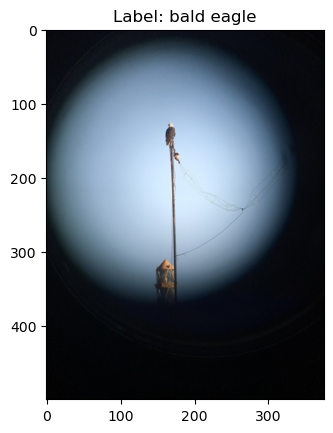

In [6]:
# DATASET CLASS TEST
def test_s3_image_folder():
    dataset = ImageNetADataset(root="imagenet-a/")
    print(f"Dataset length: {len(dataset)}")

    # Print some file names and corresponding labels - we took from README.txt
    print("Printing some file names and their corresponding labels:")
    for idx in range(5):
        key = dataset.instances[idx]
        path = Path(key)
        folder_name = path.parent.name
        label = dataset.labels[folder_name]
        print(f"File: {key}, Label: {label}")

    for idx in range(1, 500, 50):
        img, label = dataset[idx]
        plt.figure()
        plt.imshow(img)
        plt.title(f"Label: {dataset.classes[label]}")
        plt.show()


test_s3_image_folder()

In [7]:
# Augmentation Pipeline /// TODO: Augmentations will be changed
def get_augmentation_pipeline():
    #augmix = AugMix()
    #rand_augment = RandAugment(num_ops=2, magnitude=9)
    return transforms.Compose([
        #transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomResizedCrop(224),

        #rand_augment,
        #augmix,
        
        #transforms.RandomRotation(30),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomCrop(random.randint(160, 224)),
        #transforms.Resize(224),
        #transforms.ToTensor()
    ])

class AugMix:
    def __init__(self, severity=3, width=3, depth=-1, alpha=1.0):
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha
        self.augmentations = [
            transforms.RandomAffine(degrees=(0, 20), translate=(0.1, 0.3)),            
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
            self.apply_colormap,
            self.apply_grayscale,
            self.apply_histogram_equalization,
            self.apply_color_space,
        ]

    def apply_colormap(self, image):
        colormaps = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]
        colormap = np.random.choice(colormaps)
        image = np.array(image)
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        colored_image = colormap(image[..., 0] / 255.0)
        colored_image = (colored_image[..., :3] * 255).astype(np.uint8)
        return Image.fromarray(colored_image)

    def apply_grayscale(self, image):
        return ImageOps.grayscale(image).convert("RGB")

    def apply_color_space(self, image):
        image = np.array(image)
        color_spaces = [cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2LAB]
        color_space = np.random.choice(color_spaces)
        image_cs = cv2.cvtColor(image, color_space)
        image_cs = cv2.cvtColor(image_cs, cv2.COLOR_HSV2RGB if color_space == cv2.COLOR_RGB2HSV else cv2.COLOR_LAB2RGB)
        return Image.fromarray(image_cs)

    def apply_histogram_equalization(self, image):
        image = np.array(image)
        img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        img_yuv[..., 0] = cv2.equalizeHist(img_yuv[..., 0])
        img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return Image.fromarray(img_rgb)

    def __call__(self, image):
        ws = np.float32(np.random.dirichlet([self.alpha] * self.width))
        m = np.float32(np.random.beta(self.alpha, self.alpha))

        mix = torch.zeros_like(transforms.ToTensor()(image))
        for i in range(self.width):
            image_aug = image.copy()
            depth = self.depth if self.depth > 0 else np.random.randint(1, 4)
            for _ in range(depth):
                op = np.random.choice(self.augmentations)
                image_aug = op(image_aug)
            image_aug = transforms.ToTensor()(image_aug)
            if image_aug.size() != mix.size():
                image_aug = transforms.Resize((224, 224))(image_aug)
            mix += ws[i] * image_aug

        mixed = (1 - m) * transforms.ToTensor()(image) + m * mix
        return transforms.ToPILImage()(mixed)

In [8]:
# Marginal Entropy Criterion // TODO: Show/Illustrate or explain about it, why marginal entropy, what is it etc. Maybe add some Latex Formula
def marginal_entropy(outputs):
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1), avg_logits

In [9]:
class CLIPZeroShotModel:
    ''' build a custom model class based on the CLIP model '''
    def __init__(self, model_name='ViT-B/16', device='cuda'):
        self.device = device # define the device, cuda if possible
        self.model, self.preprocess = clip.load(model_name, device=device) # extract the model and the preprocessing function from clip
        self.text_embeddings = None # initialize the text embedding variable
        self.scaler = GradScaler() # 
        self.initial_state = copy.deepcopy(self.model.state_dict()) # create a deep copy of the default clip model

    def zero_shot_prediction(self, image):
        ''' create a prediction of a given image without training before '''
        with torch.no_grad(): # no need for gradient calculation
            if isinstance(image, torch.Tensor):
                if image.dim() == 4:
                    image = image.squeeze(0) # remove the batch dimension
                image = transforms.ToPILImage()(image) # transform to PIL Format

            image = self.preprocess(image).unsqueeze(0).to(self.device) # preprocess and normalize it on device
            image_embedding = self.model.encode_image(image).detach().cpu().numpy() # encode image as tensor - np.array
            text_embeddings = self.z_score_normalize(self.text_embeddings.T) # normalize the text prompts - np.array
            similarities = image_embedding @ text_embeddings # calculate cosine similarity
            
            return similarities.argmax(), similarities

    def z_score_normalize(self, array):
        ''' return a normalized copy of input numpy array '''
        mean = np.mean(array)
        std = np.std(array)
        return (array - mean) / std

    def test_time_adaptation(self, image, opt_lr, criterion, niter, n_augm, prior_strength, dataset):
        ''' adapt given model to image '''
        self.model.eval() # enter the evaluation mode
        nn.BatchNorm2d.prior = float(prior_strength) / float(prior_strength + 1) if prior_strength >= 0 else 1 # normalize the model parameters

        augmentation_pipeline = get_augmentation_pipeline() # initialize the augmentation pipeline
        
        loss_history = []
        self.model = self.model.to(torch.float32) # convert model parameters to float32
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=opt_lr) # select the AdamW optimizer
        #optimizer = torch.optim.SGD(self.model.parameters(), lr=opt_lr) 

        for iteration in range(niter): # number of 'training' steps
            aug_inputs = [augmentation_pipeline(transforms.ToPILImage()(image)) for _ in range(n_augm)] # save the augmented images in list
            inputs = [self.preprocess(img) for img in aug_inputs] # preprocess and normalize augmented images
            inputs = torch.stack(inputs).to(self.device) # stack augmented images tensor together
            optimizer.zero_grad() # reset calculated gradients

            text_input = torch.from_numpy(self.text_embeddings.T).to(self.device).float() # get text inputs as numpy float
            text_input /= text_input.norm(dim=-1, keepdim=True) # normalize text inputs

            augmented_outputs = self.model.encode_image(inputs) @ text_input # calculated cosine similarity for all augmented images
            main_loss, avg_logits = criterion(augmented_outputs)  # calculate loss in our case marginal entropy

            loss_history.append(main_loss.item()) # save for log
            main_loss.backward() # backpropagation - calculate the gradients
            optimizer.step() # do one optimizer step

        nn.BatchNorm2d.prior = 1 

        # Collect augmented images and their predictions
        aug_imgs, aug_labels = [], []
        #for i, input_img in enumerate(aug_inputs):
        #    pred, _ = self.zero_shot_prediction(input_img) # predict the augmented images for log
        #    aug_imgs.append(wandb.Image(input_img, caption=f"Augmentation {i+1}: Prediction: {dataset.idx_to_class[pred]}")) # append augmented images to wandb to log
        #    aug_labels.append(dataset.idx_to_class[pred]) # append label as text for log

        return loss_history, aug_imgs, aug_labels

    def reset_model(self):
        ''' reset the model to the inital state'''
        self.model.load_state_dict(self.initial_state)

In [13]:
def evaluate_one_sample(baseline, image, label, device, opt_lr, criterion, niter, n_augm, prior_strength, dataset, correct_samples):
    ''' pipeline to predict one image with baseline and with adapted model '''

    image = image.to(device)
    label = label.item()

    # reset the model weights to the initial state
    baseline.reset_model() 
    adapted = copy.deepcopy(baseline) 

    # prediction of the baseline model
    pred_baseline, simil_baseline = baseline.zero_shot_prediction(image)

    # log the result
    correct_samples["total"][label] += 1
    if pred_baseline == label:
        correct_samples["baseline"][label] += 1

    # run the test-time adaptation
    loss_history, aug_imgs, aug_labels = adapted.test_time_adaptation(image, opt_lr, criterion, niter, n_augm, prior_strength, dataset)

    # prediction of the adapted model
    pred_adapted, simil_adapted = adapted.zero_shot_prediction(image)

    # log the result 
    if pred_adapted == label:
        correct_samples["adapted"][label] += 1

    pred_changed = 1 if pred_baseline != pred_adapted else 0 # Determine if the prediction changed

    # Log original and augmented images with predictions to wandb
    #image_original_pil = transforms.ToPILImage()(image.cpu())
    #label_original = dataset.idx_to_class[label]
    #zero_shot_label = dataset.idx_to_class[pred_baseline]
    #adapted_label = dataset.idx_to_class[pred_adapted]
    #original_image_wandb = wandb.Image(
    #    image_original_pil, 
    #    caption=f"Original Label: {label_original}, Baseline Prediction: {zero_shot_label}, TTA Prediction: {adapted_label}"
    #    )
    #augmentation_table.add_data(label_original, pred_baseline, pred_adapted, pred_changed) # Add data to the existing table

    return pred_baseline, pred_adapted, loss_history, aug_imgs, aug_labels, correct_samples


In [ ]:

# log to wandb
#wandb.init(project="imagenet-adaptation-zehra")
#columns = ["Original Label", "Baseline Label", "Adapted Label", "Prediction Changed"]
#augmentation_table = wandb.Table(columns=columns)

# define your dataset root directory
root_dir = "imagenet-a/"

# set seed to ensure that all operations are deterministic on GPU (if used)
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# load data
dataset = ImageNetADataset(root=(root_dir), transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # initialize device
clip_model = CLIPZeroShotModel(device=device) # initialize CLIPZeroShotModel instance

# Initialize text prompts for CLIP
text_prompts = [f"Identify the {cls} in this image." for cls in dataset.classes]
text_tokens = clip.tokenize(text_prompts).to(device)
clip_model.text_embeddings = clip_model.model.encode_text(text_tokens).detach().cpu().numpy()
criterion = marginal_entropy

# define hyperparameters
hyperparameter_defaults = {
    "lr": 3e-6,
    "niter": 1,
    "prior_strength": 16.0,
    "batch_size": 16,
}
#wandb.config.update(hyperparameter_defaults)

# placeholder for logging accuracy
correct_samples = {
    "baseline": [0]*dataset.n_label, 
    "adapted": [0]*dataset.n_label, 
    "total": [0]*dataset.n_label
}

i = 0
# Evaluate samples
for image, label in data_loader:
    image = image[0]
    label = label[0]
    i += 1

    # run pipeline
    pred_baseline, pred_adapted, loss_history, aug_imgs, aug_labels, correct_samples = evaluate_one_sample(
        clip_model,
        image,
        label,
        device,
        hyperparameter_defaults['lr'],
        criterion,
        hyperparameter_defaults['niter'],
        hyperparameter_defaults['batch_size'],
        hyperparameter_defaults['prior_strength'],
        dataset, 
        correct_samples
    )

    # Log metrics with WandB
    #wandb.log({
    #    "Original Image":       [wandb.Image(image.cpu(), caption=f"Original Label: {dataset.classes[label]}, \nBaseline Label: {dataset.classes[pred_baseline]}, \nAdapted Label: {dataset.classes[pred_adapted]}")],
    #    "Baseline Prediction": dataset.classes[pred_baseline],
    #    "Adapted Prediction":   dataset.classes[pred_adapted],
    #    "Label":                dataset.classes[label],
    #    "Augmented Images":     [wandb.Image(aug[0], caption=f"Augmentation {i+1}: {aug[1]}") for i, aug in enumerate(zip(aug_imgs, aug_labels))],
    #    "Iteration Losses":     loss_history
    #})

    current_acc_b = sum(correct_samples['baseline']) / sum(correct_samples['total'])
    current_acc_a = sum(correct_samples['adapted']) / sum(correct_samples['total'])
    print(
        f"i: {i}",
        f"Label: {label}",
        f"B Pred: {pred_baseline}, ",
        f"A Pred: {pred_adapted}, ",
        f"B Acc: {(100*current_acc_b):.2f}",
        f"A Acc: {(100*current_acc_a):.2f}",
        f"B total: {sum(correct_samples['baseline']):.0f}",
        f"A total: {sum(correct_samples['adapted']):.0f}",
        end="                     \r",
        )
    if i % 100 == 0:
        print('\n')

# Calculate accuracy
baseline_accuracy = sum(correct_samples["baseline"]) / sum(correct_samples["total"])
adapted_accuracy = sum(correct_samples["adapted"]) / sum(correct_samples["total"])
print(
    "\n Overall Accuracy \n",
    f"  Zero-Shot:  {100*baseline_accuracy:.2f}",
    f"  Adapted:    {100*adapted_accuracy:.2f}"),

#wandb.log({"Baseline Accuracy": baseline_accuracy, "Adapted Accuracy": adapted_accuracy})

df = pd.DataFrame(correct_samples)
df['label'] = dataset.classes
df['total'].replace(0, 1e-9)
df['baseline accuracy'] = df['baseline'] / df['total']
df['adapted accuracy'] = df['adapted'] / df['total']


# save results to csv
df.to_csv('./results.csv')
#wandb.log({"Class Accuracies": wandb.Table(dataframe=df)})

i: 100 Label: 173 B Pred: 115,  A Pred: 115,  B Acc: 43.00 A Acc: 48.00 B total: 43 A total: 48                     

i: 200 Label: 156 B Pred: 164,  A Pred: 94,  B Acc: 39.50 A Acc: 44.50 B total: 79 A total: 89                      

i: 300 Label: 52 B Pred: 60,  A Pred: 6,  B Acc: 38.33 A Acc: 46.33 B total: 115 A total: 139                         

i: 400 Label: 101 B Pred: 164,  A Pred: 18,  B Acc: 36.75 A Acc: 46.75 B total: 147 A total: 187                      

i: 500 Label: 97 B Pred: 97,  A Pred: 97,  B Acc: 38.20 A Acc: 47.80 B total: 191 A total: 239                        

i: 600 Label: 163 B Pred: 164,  A Pred: 164,  B Acc: 38.33 A Acc: 47.83 B total: 230 A total: 287                     

i: 700 Label: 15 B Pred: 15,  A Pred: 15,  B Acc: 38.29 A Acc: 48.14 B total: 268 A total: 337                        

i: 800 Label: 121 B Pred: 121,  A Pred: 121,  B Acc: 38.25 A Acc: 48.00 B total: 306 A total: 384                     

i: 900 Label: 19 B Pred: 19,  A Pred: 19,  B